In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold #only for basic data handling, which was allowed as mentioned on piazza
IMAGE_PATH = './Medical_MNIST'
print(os.path.abspath(IMAGE_PATH))
n_components = 20
n_classes = 6

C:\Users\Acer\Desktop\sem5\ell409\Assignment_1\Medical_MNIST


In [2]:
#data_loader

#!DEL *.npz
from tqdm import tqdm
n_folds = 5
split = (n_folds-1)/n_folds #using 70:30 split, random each time
def data_loader():
    X = []
    Y = []
    
    i = 0
    for folder in os.listdir(os.path.abspath(IMAGE_PATH)):
        IMAGE_DIR = os.path.join(IMAGE_PATH, folder)
        print("Reading" + IMAGE_DIR)
        files = os.listdir(IMAGE_DIR)

        for file in tqdm(files):
            X.append((np.asarray(Image.open(os.path.join(IMAGE_DIR, file)))).reshape(-1))
            Y.append(i)

        i += 1
    print('Completed Loading Data. Saving as np file so that can directy load array nexttime')
    np.savez('q3datav2.npz', X = np.array(X), Y = np.array(Y))
    return np.array(X), np.array(Y)

if 'q3datav2.npz' in os.listdir('./'):
    zfile = np.load('q3datav2.npz')
    X_ = zfile['X']
    Y_ = zfile['Y']
else:
    X_, Y_ = data_loader()

In [3]:
h, w = 64, 64
n_classes = 6
def fastpca(X, n_pc):
    n_samples, n_features = X.shape
    mean = np.mean(X, axis=0)
    centered_data = X-mean
    svd = TruncatedSVD(n_components=n_pc, n_iter=7, random_state=42)
    svd.fit(X)
    #U, S, V = np.linalg.svd(centered_data)
    components = svd.components_
    #projected = U[:,:n_pc]*S[:n_pc]
    projected = svd.transform(X)
    return projected, components, mean, centered_data


In [4]:
def gradient_mse(X, Y, lr = 1e-9, l1_reg = 0, l2_reg = 0, n_iter=10000, batch_size=200):
    costs = []
    m = X.shape[0]
    W = np.random.rand(X.shape[1], n_classes)
    for i in tqdm(range(n_iter)):
        batch = np.random.choice(range(m), batch_size)
        X_batch = X[batch,:]
        Y_batch = Y[batch]
        
        #print(f'X_batch.shape = {X_batch.shape}')
        Y_onehot = np.zeros((Y_batch.size, n_classes))
        Y_onehot[np.arange(Y_batch.size),Y_batch] = 1
        #print(f'Y_onehot.shape = {Y_onehot.shape}')
        
        grad = 2*(X_batch.T/batch_size) @ (X_batch @ W - Y_onehot) + l1_reg*np.sign(W) + l2_reg*W
        costs.append(np.trace((X_batch @ W - Y_onehot).T @(X_batch @ W - Y_onehot))/batch_size + l1_reg*np.sum(np.abs(W)) + 0.5*l2_reg*np.sum(W*W))
        assert(grad.shape == W.shape), f'grad.shape = {grad.shape}, W.shape = {W.shape}'
        W -= lr*grad
    return W, costs

In [6]:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
CONF = []
n_iter = 1
for train_index, test_index in kf.split(X_):
    X = X_[train_index]; Y = Y_[train_index]
    X_test = X_[test_index]; Y_test = Y_[test_index]
    #performing PCA on training data
    X_red, C, M, X_centered=fastpca(X, n_pc=n_components)
    
    assert(X_red.shape[0] == X.shape[0])
    assert(X.shape[0] == Y.shape[0])
    assert(X.shape[0] != X_.shape[0])
    X_red = np.concatenate((np.ones((X_red.shape[0], 1)), X_red), axis = 1)
    W_reg, costs = gradient_mse(X_red, Y, lr=1e-8, l1_reg = 1e-2, l2_reg=1e-2, batch_size = 1000, n_iter=5000)
    
    Y_pred = np.concatenate((np.ones( (X_test.shape[0], 1)), X_test @ C.T), axis = 1) @ W_reg
    Y_pred = np.argmax(Y_pred, axis = 1)
    assert(Y_pred.shape[0] == X_test.shape[0])
    
    conf = np.zeros((n_classes, n_classes))
    for i in tqdm(range(Y_pred.shape[0])):
        conf[Y_pred[i], Y_test[i]] += 1

    
    CONF.append(conf)
    print(f'{n_iter} fold done.')
    n_iter += 1


    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11791/11791 [00:00<00:00, 214956.48it/s]


1 fold done.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11791/11791 [00:00<00:00, 89564.72it/s]


2 fold done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11791/11791 [00:00<00:00, 181884.19it/s]


3 fold done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11791/11791 [00:00<00:00, 206458.37it/s]


4 fold done.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11790/11790 [00:00<00:00, 157619.79it/s]


5 fold done.


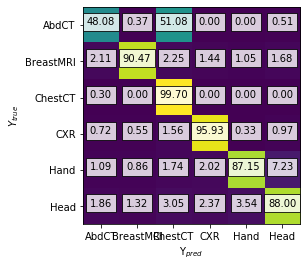

In [9]:
conf_ = np.mean(CONF, axis=0)
conf = conf_.T
conf = conf/np.sum(conf, axis=1)
plt.imshow(conf)
classes = ['AbdCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'Head']
plt.ylabel('$Y_{true}$')
plt.xlabel('Y$_{pred}$')
plt.xticks(np.arange(n_classes), classes)
plt.yticks(np.arange(n_classes), classes)
for i in range(conf.shape[0]):
    for j in range(conf.shape[1]):
        plt.text(j, i, "{:0.2f}".format(float(conf[i][j]*100)), horizontalalignment='center', bbox = dict(facecolor='white',alpha=0.8))

In [21]:
#per class precission, recall
diag = np.arange(n_classes)
acc = np.sum(conf_[diag, diag])/np.sum(conf_)*100

print('Accuracy = {:0.3f}'.format(acc))

#per class precision, recall
P = []
R = []
F = []
for i in range(n_classes):
    P.append(conf_[i,i]/np.sum(conf_[i,:]))
    R.append(conf_[i,i]/np.sum(conf_[:,i]))
    F.append(2*P[i]*R[i]/(P[i] + R[i]))
    print('{}: p = {:0.3f}, r = {:0.3f}, f = {:0.3f}'.format(classes[i], P[i]*100, R[i]*100, F[i]*100))
macro_f = sum(F)/len(F)
print('Macro-F1 score = {:0.3f}'.format(macro_f*100))

Accuracy = 84.790
AbdCT: p = 88.774, r = 48.080, f = 62.377
BreastMRI: p = 96.694, r = 90.474, f = 93.480
ChestCT: p = 62.555, r = 99.700, f = 76.876
CXR: p = 94.271, r = 95.930, f = 95.093
Hand: p = 94.656, r = 87.150, f = 90.748
Head: p = 89.440, r = 88.000, f = 88.714
Macro-F1 score = 84.548
